In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # GPU 메모리 제한 설정 (필요에 따라 수정 가능)
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]
        )
        print("GPU 설정 완료")
    except RuntimeError as e:
        print(e)

2024-11-30 14:25:48.094210: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-30 14:25:48.111033: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-30 14:25:48.115761: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-30 14:25:48.128425: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-30 14:25:48.958318: W tensorflow/compiler/tf2

GPU 설정 완료


I0000 00:00:1732944349.916290   32464 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732944349.955503   32464 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732944349.955860   32464 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.


- Dataset 분류 항목을 8 -> 4 개로 통합 
- Early Stopping 적용
- 128 * 128
- 50 epochs

> BUS         -> BUS
>            
> Bike        -> Bike
>            
> HatchBack   -> Common <br>
> SUV <br>
> Sedan <br>
> Van
> 
> Truck       -> Truck <br>
> Truck2


In [5]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import math

# 디렉토리 경로 설정 (이미지 폴더가 클래스별로 분류되어 있어야 함)
train_dir = '../../Dataset_4_class/Train'  # 학습 데이터 폴더 경로
validation_dir = '../../Dataset_4_class/Test'  # 검증 데이터 폴더 경로

# 이미지 데이터 생성기 설정
train_datagen = ImageDataGenerator(
    rescale = 1.0 / 255,  # 이미지 픽셀 값을 0~1로 정규화
    rotation_range = 20,  # 회전
    width_shift_range = 0.2,  # 수평 이동
    height_shift_range = 0.2,  # 수직 이동
    shear_range = 0.2,  # 기울이기
    zoom_range = 0.2,  # 확대
    horizontal_flip = True,  # 수평 반전
    fill_mode = 'nearest'  # 빈 부분 채우기
)

validation_datagen = ImageDataGenerator(rescale = 1.0 / 255)

# 데이터 로드
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

# steps_per_epoch 및 validation_steps 계산
import math
steps_per_epoch = math.ceil(train_generator.samples / train_generator.batch_size)
validation_steps = math.ceil(validation_generator.samples / validation_generator.batch_size)

print(f"Steps per epoch: {steps_per_epoch}, Validation steps: {validation_steps}")


# MobileNet 모델 설정
base_model = tf.keras.applications.MobileNet(
    input_shape=(128, 128, 3),
    include_top=False,
    weights=None
)

base_model.trainable = True

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(4, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='loss',  # loss 기준으로 설정
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    validation_data = validation_generator,
    epochs=10,
    # callbacks=[early_stopping]
)

# 모델 저장
model.save('MobileNet_no_weights.h5')
print("학습 완료 및 모델 저장 완료")


Found 33536 images belonging to 4 classes.
Found 5851 images belonging to 4 classes.
Steps per epoch: 1048, Validation steps: 183


I0000 00:00:1732944431.462122   32464 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732944431.462510   32464 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732944431.462766   32464 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732944431.682331   32464 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-30 14:27:11.682381: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2112] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.

Epoch 1/10


I0000 00:00:1732944442.022954     598 service.cc:146] XLA service 0x7f9928002db0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732944442.023002     598 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 SUPER, Compute Capability 7.5
2024-11-30 14:27:22.296668: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-30 14:27:23.398867: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-11-30 14:27:27.239230: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng28{k2=2,k3=0} for conv (f32[32,32,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,129,129]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}), window={size=3x3 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operati

1048/1048 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.5247 - loss: 1.0754

/home/terakawa/anaconda3/envs/kadai_wsl/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1048/1048 ━━━━━━━━━━━━━━━━━━━━ 576s 510ms/step - accuracy: 0.5248 - loss: 1.0752 - val_accuracy: 0.7973 - val_loss: 0.4945
Epoch 2/10
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 529s 504ms/step - accuracy: 0.7734 - loss: 0.5602 - val_accuracy: 0.8957 - val_loss: 0.2699
Epoch 3/10
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 919s 877ms/step - accuracy: 0.8278 - loss: 0.4338 - val_accuracy: 0.9175 - val_loss: 0.2275
Epoch 4/10
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 579s 553ms/step - accuracy: 0.8670 - loss: 0.3531 - val_accuracy: 0.9301 - val_loss: 0.1984
Epoch 5/10
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 816s 778ms/step - accuracy: 0.8866 - loss: 0.2988 - val_accuracy: 0.9190 - val_loss: 0.2313
Epoch 6/10
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 657s 627ms/step - accuracy: 0.9103 - loss: 0.2417 - val_accuracy: 0.9438 - val_loss: 0.1688
Epoch 7/10
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 449s 429ms/step - accuracy: 0.9240 - loss: 0.2082 - val_accuracy: 0.9559 - val_loss: 0.1270
Epoch 8/10
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 375s 357ms/step - accuracy: 0.9

학습 완료 및 모델 저장 완료


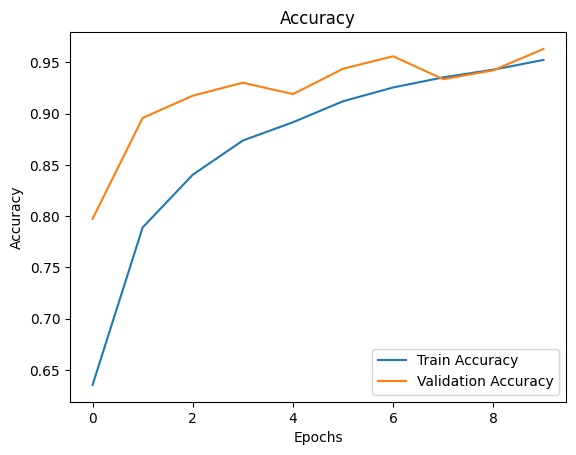

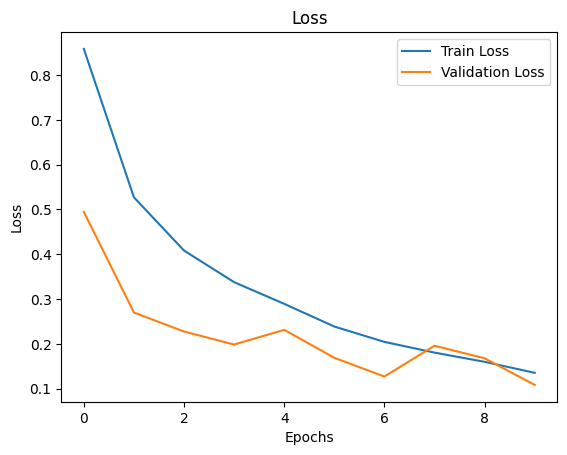

In [6]:
import matplotlib.pyplot as plt

# 학습 및 검증 정확도 그래프
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("1")
plt.show()

# 학습 및 검증 손실 그래프
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("2")
plt.show()

Found 5851 images belonging to 4 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━

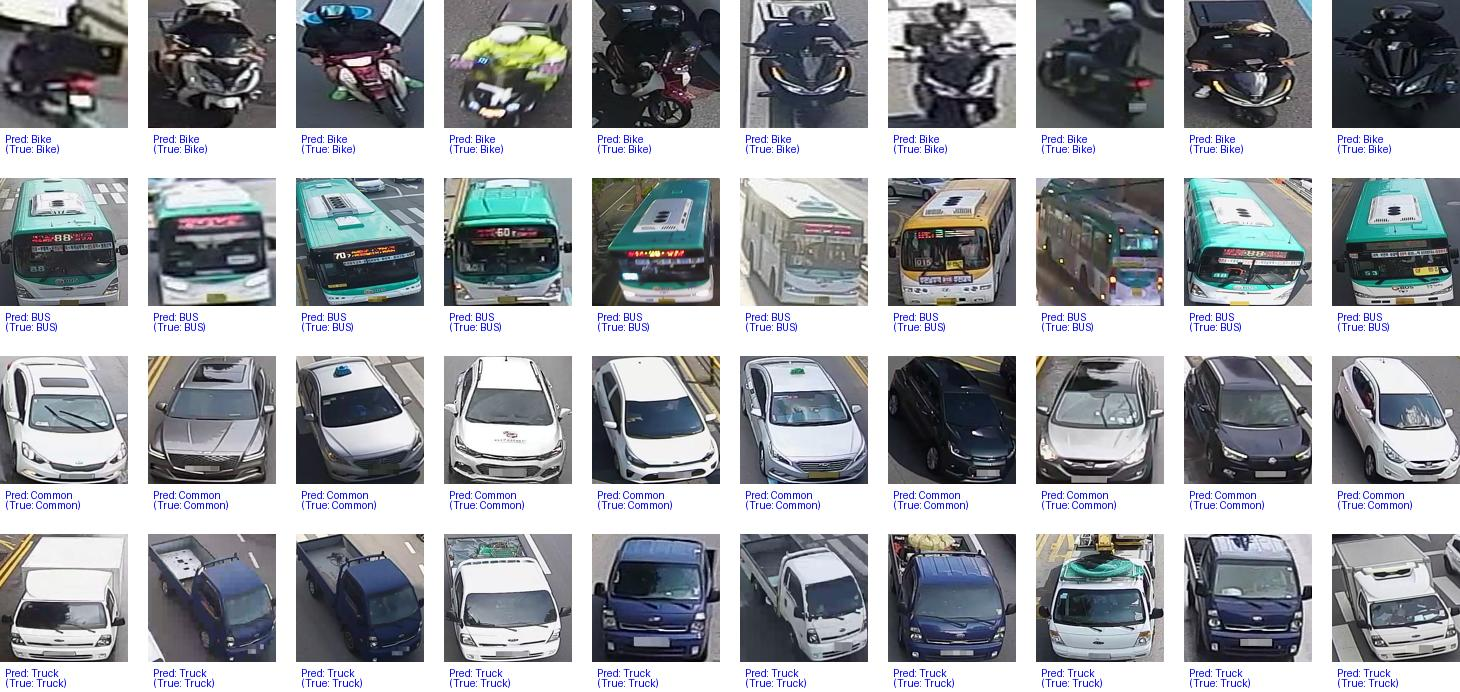

In [7]:
import os
import random
from PIL import Image, ImageDraw, ImageFont
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet import preprocess_input
import numpy as np

# 모델 로드
model = load_model('MobileNet_no_weights.h5')

# 데이터 경로와 클래스 설정
test_dir = '../../Dataset_4_class/Test'

# 인덱스가 파일시스템 정렬에 변동되는 문제 개선
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator()
test_generator = datagen.flow_from_directory(test_dir)
class_indices = test_generator.class_indices

index_to_class = {v: k for k, v in class_indices.items()}  # 인덱스 -> 클래스 이름 매핑

# 모델 입력 크기
img_size = (128, 128)  # 모델 입력 크기

# 여백 설정
padding = 20  # 이미지 간 여백 (픽셀 단위)
text_height = 30  # 텍스트 영역 높이

# 랜덤 샘플 테스트
results = []
for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)
    if not os.path.isdir(class_path):  # 디렉토리인지 확인
        continue
    
    # 해당 클래스 폴더의 모든 파일 가져오기
    images = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
    
    # 랜덤으로 10개 선택 (이미지가 10개 미만이면 모두 선택)
    sampled_images = random.sample(images, min(10, len(images)))
    
    # 예측 수행
    for image_path in sampled_images:
        # 이미지 로드 및 전처리
        img = load_img(image_path, target_size=img_size, color_mode='rgb')
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # 예측
        predictions = model.predict(img_array)
        predicted_index = np.argmax(predictions, axis=1)[0]
        predicted_class = index_to_class[predicted_index]

        # 결과 저장
        results.append({
            'image': image_path,
            'predicted_class': predicted_class,
            'true_class': class_name
        })

# 이미지 합치기
num_images_per_row = 10  # 가로에 표시할 이미지 수
output_width = img_size[0] * num_images_per_row + padding * (num_images_per_row - 1)  # 가로 크기
num_rows = (len(results) + num_images_per_row - 1) // num_images_per_row  # 전체 행 수
output_height = (img_size[1] + text_height) * num_rows + padding * (num_rows - 1)  # 세로 크기
output_image = Image.new("RGB", (output_width, output_height), "white")

# 폰트 설정 (기본 폰트 사용)
try:
    font_path = "C:/Windows/Fonts/arial.ttf"  # Windows 시스템 기본 폰트 경로
    font = ImageFont.truetype(font_path, size=12)
except OSError:
    print("Custom font not found. Using default font.")
    font = ImageFont.load_default()

draw = ImageDraw.Draw(output_image)

# 각 이미지를 합친다
x_offset, y_offset = 0, 0
for i, result in enumerate(results):
    # 이미지 열기
    img = Image.open(result['image']).resize(img_size)
    output_image.paste(img, (x_offset, y_offset))
    
    # 예측 텍스트 추가 (이미지 아래, 개행 포함)
    text = f"Pred: {result['predicted_class']}\n(True: {result['true_class']})"
    text_color = "blue" if result['predicted_class'] == result['true_class'] else "red"  # 색상 결정
    
    # 여러 줄 텍스트 작성
    text_x = x_offset + 5
    text_y = y_offset + img_size[1] + 5  # 이미지 바로 아래
    for line in text.split("\n"):  # 개행 기준으로 나누어 작성
        draw.text((text_x, text_y), line, fill=text_color, font=font)
        text_y += 10  # 줄 간격 추가 (폰트 크기 고려)

    # 다음 위치로 이동
    x_offset += img_size[0] + padding
    if x_offset >= output_width:  # 한 줄이 가득 찼을 경우
        x_offset = 0
        y_offset += img_size[1] + text_height + padding

output_image_path = "MobileNet_no_weights_combined_predictions_colored_text.jpg"
output_image.save(output_image_path)
output_image = Image.open(output_image_path)
display(output_image)